## Notebook Purpose

create, view different versions of poisson disc mask

In [2]:
import os, sys
import numpy as np
import numba as nb
import torch
import matplotlib.pyplot as plt
import sigpy
from sigpy.mri.samp import poisson

# TODO

- generate two non-overlapping poisson disc masks dependently
    - source code: https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.poisson.html?highlight=poisson#sigpy.mri.poisson

In [3]:
def sample_square_central_region(mask):
    ''' force central 64x64=4096 region to be 1's'''
    
    C = 32    
    idx_y, idx_z = mask.shape[0] // 2, mask.shape[1] // 2
    
    mask[idx_y-C:idx_y+C, idx_z-C:idx_z+C] = 1
    
    return mask

def sample_rectangular_central_region(mask):
    ''' force central rectangular region of pixels to 1
        want 4096 pixels, b/c originally did a 64 * 64 = 4096 square region
        to be rectangular, find x s.t. (160/x) * (512/x) = 4096 --> x ~= 8.9 '''
    
    size_region = 4096
    num_y, num_z = mask.shape[0], mask.shape[1] # number of pixels in (y,z)
    mid_y, mid_z = num_y // 2, num_z // 2 # middle index in (y,z)
    sf = np.sqrt((num_y * num_z) / size_region) # scaling factor
    len_y, len_z = int(num_y / (2*sf)) + 1, \
                   int(num_z / (2*sf)) + 1 # length from center, hence div by 2
    mask[mid_y-len_y:mid_y+len_y, mid_z-len_z:mid_z+len_z] = 1
    
    return mask

def create_poisson_disc(accel, img_shape=(512,160), seed=None):
    ''' create a poisson disc mask, set central pixel region to 1 
        calculate + print actual undersampling factor '''
    
    # create mask
    mask = poisson(img_shape=img_shape, accel=accel, seed=seed)
    mask = torch.from_numpy(mask)
    mask = abs(mask).type(torch.uint8)

#     mask = sample_rectangular_central_region(mask)
    mask = sample_square_central_region(mask)
    
    accel_adj = float(1. / (torch.count_nonzero(mask) / (512*160)))
    print('given accel {}, factor adjusted to {} after forcing 1s'.format(
        accel, np.round(accel_adj,4)))
    
    return mask

### generate poisson disc masks

- [accel, accel_adj]: [4.65, 4], [12, 8]
- only save masks w accel_adj on [X, X.01] for X=4,8

In [102]:
accel = 12

mask1 = create_poisson_disc(accel)
mask2 = create_poisson_disc(accel)

given accel 12, factor adjusted to 8.0345 after forcing 1s
given accel 12, factor adjusted to 8.0094 after forcing 1s


In [6]:
accel_adj = 8
path_m = '/home/vanveen/ConvDecoder/masks/'
# np.save('mask_poisson_disc_{}x_v2.npy'.format(path_m, accel_adj), mask2)

mask1 = np.load('{}mask_poisson_disc_{}x_v1.npy'.format(path_m, accel_adj))
mask2 = np.load('{}mask_poisson_disc_{}x_v2.npy'.format(path_m, accel_adj))
mask1, mask2 = torch.from_numpy(mask1), torch.from_numpy(mask2)

### if i generate two random masks iid, how much overlap will there be?
- percentage of redundant pixels, discounting central region
    - accel=4: 26.7%
    - accel=8: 10.0%

In [7]:
# average number of 1's in each mask, discounting central region
num_1s = 0.5 * (torch.count_nonzero(mask1) + torch.count_nonzero(mask2))
num_1s = num_1s - 4096 # deduct central region from count

# overlapping 1's, discounting central region
mask_and = torch.logical_and(mask1, mask2)
num_1s_and = torch.count_nonzero(mask_and) - 4096

# percentage overlap, discounting central region
num_1s_and / num_1s

tensor(0.0996)

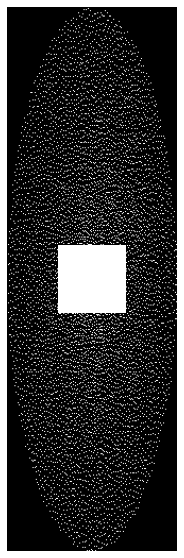

In [8]:
FIGSIZE=10
plt.figure(figsize=(FIGSIZE,FIGSIZE))
plt.axis('off')
plt.imshow(mask1, cmap='gray')

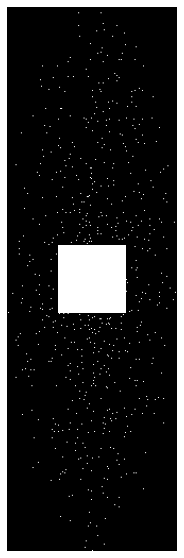

In [10]:
FIGSIZE=10
plt.figure(figsize=(FIGSIZE,FIGSIZE))
plt.axis('off')
plt.imshow(mask_and, cmap='gray')